In [2]:
import pandas as pd
import json
import os

# List of all countries available in your dataset
countries = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']

# Folder where all CSV and JSON files are stored
data_path = r'C:\Users\Admin\Desktop\Data Analyst\Youtube Analytics\archive'


# Create a list to hold all DataFrames
all_dfs = []

for country in countries:
    print(f"Processing {country}...")

    # Construct file paths
    csv_file = os.path.join(data_path, f'{country}videos.csv')
    json_file = os.path.join(data_path, f'{country}_category_id.json')

    # Load CSV
    try:
        df = pd.read_csv(csv_file, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(csv_file, encoding='latin1')


    # Load JSON and map category IDs to category names
    try:
        with open(json_file, 'r') as f:
            categories = json.load(f)
        cat_map = {int(item['id']): item['snippet']['title'] for item in categories['items']}
    except (FileNotFoundError, KeyError, ValueError):
        print(f"JSON file or parsing issue for {country}. Skipping category mapping.")
        cat_map = {}

    # Add new columns
    df['category'] = df['category_id'].map(cat_map)
    df['country'] = country

    # Convert trending date to proper datetime (some datasets use different format)
    try:
        df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
    except:
        df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')

    # Append cleaned DataFrame
    all_dfs.append(df)

# Combine all data
all_data = pd.concat(all_dfs, ignore_index=True)

# Preview
print("Combined Data Shape:", all_data.shape)
print(all_data[['title', 'category', 'country', 'views']].head())

# Save merged data to CSV (optional)
all_data.to_csv('all_youtube_trending_data.csv', index=False)


Processing US...
Processing CA...
Processing DE...
Processing FR...
Processing GB...
Processing IN...
Processing JP...
Processing KR...
Processing MX...
Processing RU...
Combined Data Shape: (375942, 18)
                                               title        category country  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE  People & Blogs      US   
1  The Trump Presidency: Last Week Tonight with J...   Entertainment      US   
2  Racist Superman | Rudy Mancuso, King Bach & Le...          Comedy      US   
3                   Nickelback Lyrics: Real or Fake?   Entertainment      US   
4                           I Dare You: GOING BALD!?   Entertainment      US   

     views  
0   748374  
1  2418783  
2  3191434  
3   343168  
4  2095731  


In [13]:
!pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------- ---------- 450.6/624.3 kB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 9.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.6/1.5 MB 11.8 MB/s eta 0:00:01
   ----------------------------- ---------- 1.1/1.5 MB 14.0 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [11]:
import pandas as pd
from textblob import TextBlob

# Step 1: Load the dataset
df = pd.read_csv("all_youtube_trending_data.csv")

# Step 2: Function to compute sentiment polarity
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# Step 3: Function to convert polarity into label
def get_sentiment_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Step 4: Apply functions to title column
df['title_sentiment'] = df['title'].apply(get_sentiment)
df['sentiment_label'] = df['title_sentiment'].apply(get_sentiment_label)

# Step 5: Save updated DataFrame back to CSV
df.to_csv("all_youtube_trending_data.csv", index=False)

print("✅ 'title_sentiment' and 'sentiment_label' added and saved successfully.")


✅ 'title_sentiment' and 'sentiment_label' added and saved successfully.


In [7]:
import pandas as pd
import sqlite3

# Step 1: Save your cleaned DataFrame to SQLite
conn = sqlite3.connect("youtube_trending.db")
all_data.to_sql("trending_videos", conn, if_exists='replace', index=False)

# Step 2: SQL query to calculate average views per category
query = """
SELECT 
    category,
    ROUND(AVG(views), 2) AS avg_views
FROM 
    trending_videos
WHERE 
    category IS NOT NULL
GROUP BY 
    category
ORDER BY 
    avg_views DESC
"""

# Step 3: Execute query and show results
ranked_categories = pd.read_sql_query(query, conn)
print("Top Categories by Average Views:\n")
print(ranked_categories)

# Optional: Save to CSV
ranked_categories.to_csv("category_avg_views_ranking.csv", index=False)

# Optional: Close the DB connection
conn.close()


Top Categories by Average Views:

                 category   avg_views
0                   Music  6020771.72
1   Nonprofits & Activism  2963884.07
2                  Movies  1954438.25
3        Film & Animation  1319479.64
4    Science & Technology  1125286.40
5           Entertainment   958823.07
6                  Comedy   817607.21
7                  Sports   801065.07
8                  Gaming   672354.28
9           Howto & Style   518192.19
10                  Shows   455918.44
11         People & Blogs   436623.35
12         Pets & Animals   413011.36
13        Travel & Events   409163.83
14              Education   351160.94
15       Autos & Vehicles   351046.42
16        News & Politics   279513.60
17               Trailers    11008.60


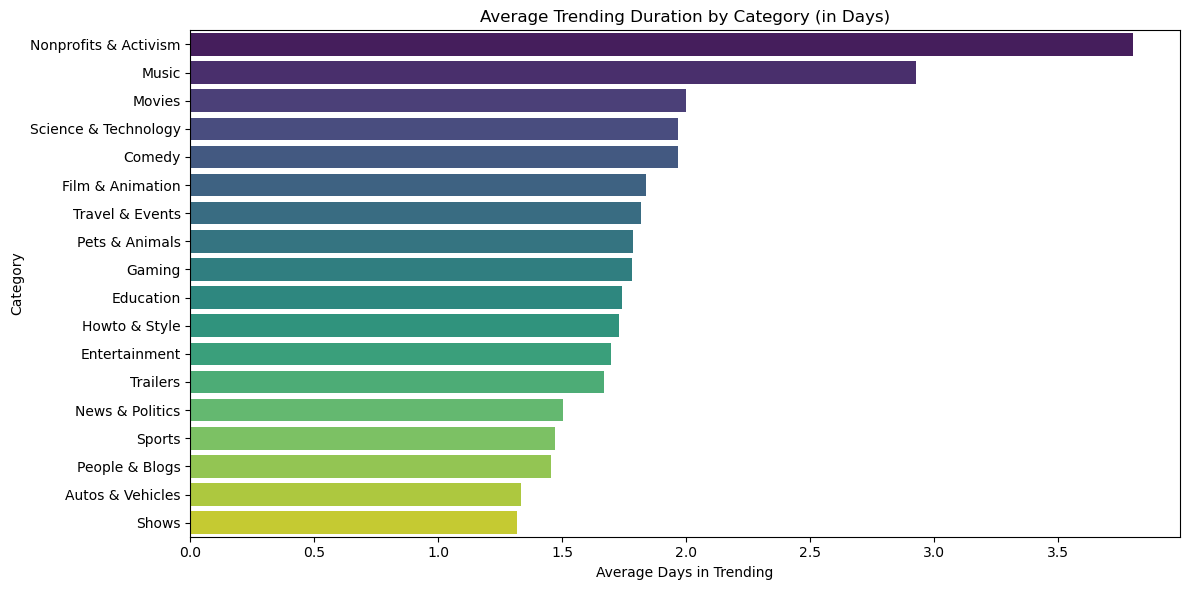

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your trending_date is in datetime format
all_data['trending_date'] = pd.to_datetime(all_data['trending_date'], errors='coerce')

# Step 1: Trending duration calculation (number of unique trending days per video)
video_duration = all_data.groupby(['video_id', 'title', 'category', 'country'])['trending_date'] \
                         .nunique().reset_index(name='trending_days')

# Step 2: Average trending duration per category
category_duration = video_duration.groupby('category')['trending_days'].mean().sort_values(ascending=False)

# Step 3: Plot average trending duration per category
plt.figure(figsize=(12, 6))
sns.barplot(x=category_duration.values, y=category_duration.index, palette='viridis')
plt.title("Average Trending Duration by Category (in Days)")
plt.xlabel("Average Days in Trending")
plt.ylabel("Category")
plt.tight_layout()
plt.show()
